In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import joblib

In [3]:
from sklearn.ensemble import RandomForestClassifier

In [4]:
import random

In [5]:
import gc

In [6]:
import utils

### Load classifiers

In [7]:
X_cols = joblib.load(utils.get_base_path('model/X_columns_full.pkl'))

In [8]:
rfc_full = joblib.load(utils.get_base_path("model/rfc-full.pkl"))

In [9]:
X_nofp_cols = joblib.load(utils.get_base_path('model/X_columns_nofp.pkl'))

In [10]:
rfc_nofp = joblib.load(utils.get_base_path("model/rfc-nofp.pkl"))

In [11]:
X_dtypes = utils.get_X_dtypes()

### Load data

In [12]:
%time full_output = pd.read_csv(utils.get_base_path("export/20210720-ch-output.csv"), index_col=0, dtype=X_dtypes)

/n/fs/grad/mmoeser/change/venv/lib64/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 5min 50s, sys: 40.7 s, total: 6min 30s
Wall time: 7min 34s


In [13]:
%time full_txes = pd.read_csv(utils.get_base_path("export/20210720-ch-tx.csv"), index_col=0, dtype=X_dtypes)

CPU times: user 4min 39s, sys: 1min 7s, total: 5min 47s
Wall time: 6min 5s


In [14]:
%time full_heuristics = pd.read_csv(utils.get_base_path("export/20210720-normal-heuristics.csv"), index_col=0, dtype=X_dtypes)

CPU times: user 3min 47s, sys: 18.5 s, total: 4min 5s
Wall time: 4min 10s


In [15]:
%time full_fp = pd.read_csv(utils.get_base_path("export/20210720-fingerprint-heuristics.csv"), index_col=0, dtype=X_dtypes)

CPU times: user 6min 57s, sys: 46.4 s, total: 7min 44s
Wall time: 7min 50s


In [16]:
assert len(full_output) == len(full_txes)
assert len(full_output) == len(full_heuristics)
assert len(full_output) == len(full_fp)

#### Modify variables to match model

In [17]:
full_txes["ct_epoch"] = full_txes["ct_block_height"] // 1008

In [18]:
full_txes.drop(columns=["ct_fee", "ct_block_height"], inplace=True)
full_output.drop(columns=["co_output_value", "co_is_larger_output", "co_fresh_output", "co_other_fresh"], inplace=True)

#### Concat individual dataframes

In [19]:
full_X_merge = pd.concat([full_output, full_txes, full_heuristics, full_fp], axis=1)

In [20]:
del full_output, full_txes, full_heuristics, full_fp

#### Check columns are correct size

In [21]:
assert len(X_cols) == len(full_X_merge.columns)

In [22]:
assert set(X_cols) == set(full_X_merge.columns)

In [23]:
(X_cols == full_X_merge.columns).all()

False

#### Reorder columns is necessary for classifiers

In [24]:
full_X = full_X_merge[X_cols]

In [25]:
assert (X_cols == full_X.columns).all()

In [26]:
del full_X_merge

#### Get a mask of transactions where there is not at least one heuristic vote

In [27]:
CHARACTERISTICS_COLS = [x for x in full_X if x[:3] == "co_" or x[:3] == "ct_"]

In [28]:
mask_at_least_one = (full_X.drop(columns=CHARACTERISTICS_COLS) != -1).any(1)

In [29]:
len(full_X), np.sum(mask_at_least_one)

(619306108, 598218668)

In [30]:
len(full_X) - np.sum(mask_at_least_one)

21087440

In [31]:
gc.collect()

264

### Update categorical variables

In [32]:
CATEGORICAL_COLUMNS = [x for x in full_X.columns if x[:3] != "ct_" and x[:3] != "co_"]

In [33]:
full_X.head()

,optimal_change,optimal_change_with_fee,address_type,power_of_ten_2,power_of_ten_3,power_of_ten_4,power_of_ten_5,power_of_ten_6,power_of_ten_7,fp_inout_count,...,fp_p2wpkh,co_output_value_ratio,co_output_index,ct_fee_per_byte,ct_tx_value,ct_version,ct_segwit_tx,ct_has_locktime,ct_input_count,ct_epoch
0,1,1,-1,-1,-1,-1,-1,-1,1,1,...,-1,0.004933,0,1124,1004978000000,1,0,False,168,28
1,0,0,-1,-1,-1,-1,-1,-1,0,0,...,-1,0.995067,1,1124,1004978000000,1,0,False,168,28
2,1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,0.004833,0,0,90000000000,1,0,False,18,28
3,0,0,0,-1,-1,-1,-1,-1,-1,-1,...,-1,0.995167,1,0,90000000000,1,0,False,18,28
4,-1,-1,0,-1,-1,-1,-1,-1,-1,-1,...,-1,0.200000,0,0,5000000000,1,0,False,1,28


#### Replace 0 and -1 values

In [34]:
for c in CATEGORICAL_COLUMNS:
    print(c)
    full_X[c] = full_X[c].replace([0, -1], [-1, 0])
    full_X[c] = pd.to_numeric(full_X[c], downcast="integer")

optimal_change
optimal_change_with_fee
address_type
power_of_ten_2
power_of_ten_3
power_of_ten_4
power_of_ten_5
power_of_ten_6
power_of_ten_7
fp_inout_count
fp_output_count
fp_zeroconf
fp_multisig
fp_p2pkh
fp_absolute_fee
fp_relative_fee
fp_version
fp_locktime
fp_rbf
fp_segwit
fp_possible_segwit
fp_ordered_inouts
fp_address_type
fp_p2sh
fp_p2wsh
fp_p2wpkh


In [35]:
# may take too much memory to run
# %time full_X[CATEGORICAL_COLUMNS] = full_X[CATEGORICAL_COLUMNS].replace([0, -1], [-1, 0])

In [36]:
# full_X[CATEGORICAL_COLUMNS] = full_X[CATEGORICAL_COLUMNS].apply(pd.to_numeric, downcast='integer')

In [37]:
full_X.dtypes

optimal_change                int8
optimal_change_with_fee       int8
address_type                  int8
power_of_ten_2                int8
power_of_ten_3                int8
power_of_ten_4                int8
power_of_ten_5                int8
power_of_ten_6                int8
power_of_ten_7                int8
fp_inout_count                int8
fp_output_count               int8
fp_zeroconf                   int8
fp_multisig                   int8
fp_p2pkh                      int8
fp_absolute_fee               int8
fp_relative_fee               int8
fp_version                    int8
fp_locktime                   int8
fp_rbf                        int8
fp_segwit                     int8
fp_possible_segwit            int8
fp_ordered_inouts             int8
fp_address_type               int8
fp_p2sh                       int8
fp_p2wsh                      int8
fp_p2wpkh                     int8
co_output_value_ratio      float64
co_output_index              uint8
ct_fee_per_byte     

In [38]:
full_X.head()

,optimal_change,optimal_change_with_fee,address_type,power_of_ten_2,power_of_ten_3,power_of_ten_4,power_of_ten_5,power_of_ten_6,power_of_ten_7,fp_inout_count,...,fp_p2wpkh,co_output_value_ratio,co_output_index,ct_fee_per_byte,ct_tx_value,ct_version,ct_segwit_tx,ct_has_locktime,ct_input_count,ct_epoch
0,1,1,0,0,0,0,0,0,1,1,...,0,0.004933,0,1124,1004978000000,1,0,False,168,28
1,-1,-1,0,0,0,0,0,0,-1,-1,...,0,0.995067,1,1124,1004978000000,1,0,False,168,28
2,1,1,1,0,0,0,0,0,0,0,...,0,0.004833,0,0,90000000000,1,0,False,18,28
3,-1,-1,-1,0,0,0,0,0,0,0,...,0,0.995167,1,0,90000000000,1,0,False,18,28
4,0,0,-1,0,0,0,0,0,0,0,...,0,0.200000,0,0,5000000000,1,0,False,1,28


#### Load mask to determine which transactions have spent outputs

In [39]:
all_spent_mask = np.load(utils.get_base_path("export/20210719_all_spent_mask.npy"))

In [40]:
all_spent_mask = np.array([val for val in all_spent_mask for _ in (0, 1)])

In [41]:
assert len(all_spent_mask) == len(full_X)

In [42]:
full_X_spent = full_X[all_spent_mask]

In [43]:
full_X_unspent = full_X[~all_spent_mask]

In [44]:
assert len(full_X_spent) == np.sum(all_spent_mask)
assert len(full_X_spent) + len(full_X_unspent) == len(full_X)

In [45]:
len(full_X_spent), len(full_X_unspent)

(580716136, 38589972)

In [46]:
full_X.memory_usage().sum()

47686570316

In [41]:
# del full_X

#### Predict transactions where outputs have been spent

In [47]:
full_X_spent_subset_1 = full_X_spent.iloc[0:200000000,]
full_X_spent_subset_2 = full_X_spent.iloc[200000000:400000000,]
full_X_spent_subset_3 = full_X_spent.iloc[400000000:,]

In [48]:
len(full_X_spent), len(full_X_spent_subset_1), len(full_X_spent_subset_2), len(full_X_spent_subset_3)

(580716136, 200000000, 200000000, 180716136)

In [49]:
full_X_spent_subset_1.memory_usage().sum() / (1000**3)

15.4

In [50]:
assert (X_cols == full_X_spent_subset_1.columns).all()
assert (X_cols == full_X_spent_subset_2.columns).all()
assert (X_cols == full_X_spent_subset_3.columns).all()
assert len(full_X_spent_subset_1) + len(full_X_spent_subset_2) + len(full_X_spent_subset_3) == len(full_X_spent)
assert len(full_X_spent_subset_1) % 2 == 0
assert len(full_X_spent_subset_2) % 2 == 0
assert len(full_X_spent_subset_3) % 2 == 0

In [51]:
gc.collect()

132

In [52]:
full_y_predict_1 = rfc_full.predict_proba(full_X_spent_subset_1)[:, 1]

In [53]:
len(full_y_predict_1)

200000000

In [54]:
full_y_predict_2 = rfc_full.predict_proba(full_X_spent_subset_2)[:, 1]

In [55]:
full_y_predict_3 = rfc_full.predict_proba(full_X_spent_subset_3)[:, 1]

In [56]:
assert len(full_y_predict_1) + len(full_y_predict_2) + len(full_y_predict_3) == len(full_X_spent)

#### Predict transactions where not all outputs have been spent

In [57]:
FINGERPRINT_COLS = [x for x in X_cols if x[:3] == "fp_"]

In [58]:
full_X_unspent = full_X_unspent.drop(columns=FINGERPRINT_COLS)

In [62]:
# make sure order is correct
full_X_unspent = full_X_unspent[X_nofp_cols]

In [ ]:
assert (X_nofp_cols == full_X_unspent.columns).all()

In [63]:
full_y_predict_unspent = rfc_nofp.predict_proba(full_X_unspent)[:, 1]

#### Reassamble full data frame

In [64]:
full_y_predict = np.concatenate([full_y_predict_1, full_y_predict_2, full_y_predict_3])

In [65]:
with_fingerprint = pd.DataFrame({"y": full_y_predict}, index=full_X_spent.index)

In [66]:
without_fingerprint = pd.DataFrame({"y": full_y_predict_unspent}, index=full_X_unspent.index)

In [67]:
full_predict = pd.concat([with_fingerprint, without_fingerprint])

In [68]:
assert len(full_predict) == len(full_X_spent) + len(full_X_unspent)
assert len(full_predict) == len(full_X)

In [69]:
full_predict.head()

,y
0,0.987940
1,0.036343
4,0.333274
5,0.703728
6,0.057266


In [72]:
full_y_predict_1[0:5]

array([0.98794039, 0.03634326, 0.33327351, 0.70372773, 0.05726625])

In [73]:
full_y_predict_unspent[0:2]

array([0.98995402, 0.00455616])

In [74]:
full_predict.sort_index(inplace=True)

In [75]:
full_predict.head()

,y
0,0.987940
1,0.036343
2,0.989954
3,0.004556
4,0.333274


In [ ]:
# export mask, we don't want to set it to 0.0 here because that makes it harder to ignore them
# instead, load the mask when we evaluate the reuslts

In [76]:
np.save(utils.get_base_path("full-prediction/20210803-mask-predict.npy"), mask_at_least_one)

In [78]:
np.save(utils.get_base_path("full-prediction/20210803-full-predict.npy"), full_predict["y"].values)

<AxesSubplot:>

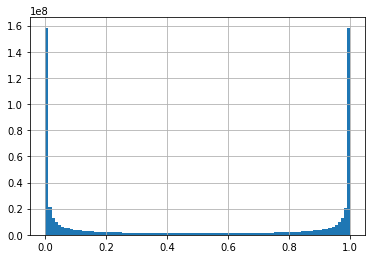

In [80]:
full_predict["y"].hist(bins=100)